### Imports and Library Setup

Import all the necessary Python libraries and packages for the notebook's workflow.


# UK Electricity Demand & Generation Forecasting: Technical Assignment

This notebook demonstrates a workflow for forecasting UK electricity demand using real-world data and machine learning. 

---

## Step-by-Step Structure

### 1. **Business Context & Problem Statement**
- **Business**: Energy trading company with narrow profit margins, relying on accurate short-term demand forecasts.
- **Problem**: The current naive baseline forecast shows significant prediction errors, impacting trading performance.
- **Goal**: Develop and evaluate advanced forecasting models, and test additional features to improve 0–24 hour demand prediction.

---

### 2. **Data Acquisition & Preparation**
- **Datasets**:
    - UK electricity demand (2009–2024)
    - UK electricity generation by source (2009–2024)
- **Data Loading**:
    - Download demand data from Kaggle and generation data from NESO API.
    - Parse, clean, and join both datasets on a common `datetime` column.
- **Preprocessing**:
    - Handle time intervals (settlement periods), missing values, and daylight saving issues.
    - Drop unnecessary columns and ensure consistent datetime formatting.

---

### 3. **Exploratory Data Analysis (EDA)**
- **Visualization**:
    - Plot hourly, daily, weekly, monthly, and yearly averages for demand and generation.
    - Use interactive Plotly charts to explore trends and seasonality.
- **Insights**:
    - Identify patterns, anomalies, and potential feature engineering opportunities.

---

### 4. **Baseline Model Definition**
- **Model**: 7-day mean demand at the same time of day (simple historical average).
- **Evaluation**:
    - Predict demand in rolling 24-hour windows for December 2023.
    - Visualize predictions vs. actuals.
    - Calculate RMSE and MAPE for each 24-hour window.
    - Calculate mean RMSE and MAPE for all windows that month.

---

### 5. **Machine Learning Models**
- **Model 1**: Gradient Boosting Regressor (GBR):
    - Day of week, hour of day, 24 h lagged demand.
- **Model 2**: LightGBM Regressor.

- **Training & Testing**:
    - Train on Janurary 2013 – November 2023 data, test on December 2023.
    - Make predictions for rolling 24-hour windows.
    - Calculate RMSE and MAPE for each 24-hour window.
    - Calculate mean RMSE and MAPE for all windows that month.
- **Visualization**:
    - Plot model predictions vs. actuals for each window.

---

### 6. **Model Comparison**
- **Metrics**:
    - Compare RMSE across baseline and ML model for each day in December 2023.

---

### 7. **Feature Engineering & Further Improvements**
- **Analysis**:
    - Identify which features are the most impportant for the forecast.
- **Next Steps**:
    - Suggest further data sources (weather, market prices, holidays).
    - Propose advanced modeling approaches (e.g., deep learning, exogenous variables).

---

## **Summary**

This notebook provides a reproducible, step-by-step approach to:
- Data ingestion and cleaning
- Exploratory analysis
- Baseline and advanced ML modeling
- Model evaluation and comparison
- Feature engineering insights

It is designed to showcase both technical skills and business understanding for a real-world energy forecasting challenge.

In [36]:
import os
import time
import shutil
import requests
import kagglehub
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image, display

from datetime import datetime, timedelta

from lightgbm import LGBMRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

### UK Electricity Demand Data Acquisition and Preparation

Downloading the data from Kaggle (https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022/data). 

The time is stored in 'settlement_period' as 1-48 30-minute windows. I convert them to hours and minutes, merge with date to make datetime format column.

In [37]:
# Download all UK electricity demand files from Kaggle dataset
path = kagglehub.dataset_download("albertovidalrod/electricity-consumption-uk-20092022")
print("Path to dataset files:", path)

# Copy historic_demand_2009_2024.csv to data folder in the parent directory (where notebooks folder is)
csv_name = "historic_demand_2009_2024.csv"
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, "data")
os.makedirs(data_dir, exist_ok=True)
src = os.path.join(path, csv_name)
dst = os.path.join(data_dir, csv_name)
shutil.copy(src, dst)
print(f"Copied {csv_name} to data folder: {dst}")

# Read CSV directly with Polars
df_dmnd = pl.read_csv(dst)

# Calculate datetime for each settlement_period (1-24, each is a 30-min interval)
df_dmnd = df_dmnd.with_columns(
    (pl.col('settlement_date') + " " + pl.format("{}:{}", 
        ((pl.col('settlement_period') - 1) * 30 // 60).cast(pl.Utf8).str.zfill(2),
        ((pl.col('settlement_period') - 1) * 30 % 60).cast(pl.Utf8).str.zfill(2)
    )).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M", strict=False).alias('datetime')
)

# Drop rows where datetime is null (due to day-time saving time issues)
df_dmnd = df_dmnd.filter(pl.col('datetime').is_not_null())

# Sort by datetime (Polars does not have a true index)
df_dmnd = df_dmnd.sort('datetime')

# Drop unwanted columns
cols_to_drop = ["settlement_period", "settlement_date", ""] 
df_dmnd = df_dmnd.drop(cols_to_drop)

# Reorder columns to have datetime first
cols = ['datetime'] + [col for col in df_dmnd.columns if col != 'datetime']
df_dmnd = df_dmnd.select(cols)

print("Demand DataFrame columns:", df_dmnd.columns)
print(df_dmnd.head(10))



Path to dataset files: /Users/vadimbogatyr/.cache/kagglehub/datasets/albertovidalrod/electricity-consumption-uk-20092022/versions/85
Copied historic_demand_2009_2024.csv to data folder: /Users/vadimbogatyr/VSCode/adaptfy_uk_energy/UK-energy/data/historic_demand_2009_2024.csv
Demand DataFrame columns: ['datetime', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday']
shape: (10, 22)
┌─────────────┬───────┬───────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ datetime    ┆ nd    ┆ tsd   ┆ england_wa ┆ … ┆ scottish_t ┆ viking_flo ┆ greenlink_ ┆ is_holiday │
│ ---         ┆ ---   ┆ ---   ┆ les_demand ┆   ┆ ransfer    ┆ w          ┆ flow       ┆ ---       

### UK Electricity Generation Data Acquisition and Preparation

NESO Energy data: https://www.neso.energy/data-portal/historic-generation-mix/historic_gb_generation_mix#

Retrieve electricity generation data using API. Parse and clean the data.

In [38]:
# NESO energy generation mix resource_id from the example
resource_id = "f93d1835-75bc-43e5-84ad-12472b180a98"

# CKAN API endpoint
url = "https://api.neso.energy/api/3/action/datastore_search"

# Query parameters
params = {
    "resource_id": resource_id,
    "limit": 500000  # Adjust limit as needed
}

response = requests.get(url, params=params)
data = response.json()

# Convert records to Polars DataFrame
records = data['result']['records']
df_gnrt = pl.DataFrame(records)

# Parse DATETIME to polars datetime
df_gnrt = df_gnrt.with_columns(
    pl.col("DATETIME").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S", strict=False).alias("datetime")
)

# Split into date and time columns
df_gnrt = df_gnrt.with_columns([
    pl.col("datetime").dt.strftime("%Y-%m-%d").alias("date"),
    pl.col("datetime").dt.strftime("%H:%M").alias("time")
])

# Drop 'DATETIME', '_id', and any Unnamed columns
cols_to_drop = ["DATETIME", "_id", "date", "time"]
df_gnrt = df_gnrt.drop(cols_to_drop)

# Lowercase all column names
df_gnrt.columns = [col.lower() for col in df_gnrt.columns]

# Bring 'datetime' to the beginning
df_gnrt = df_gnrt.select(["datetime"] + [col for col in df_gnrt.columns if col != "datetime"])

print("Demand DataFrame columns:", df_gnrt.columns)
print(df_gnrt.head(10))

print("Dataframe shape:", df_gnrt.shape)

# Save to CSV in the data folder (in the same folder as the notebooks folder)
gen_csv_name = "historic_generation_2009_2024.csv"
gen_csv_path = os.path.join(parent_dir, "data", gen_csv_name)
df_gnrt.write_csv(gen_csv_path)
print(f"Saved generation data to: {gen_csv_path}")

Demand DataFrame columns: ['datetime', 'gas', 'coal', 'nuclear', 'wind', 'wind_emb', 'hydro', 'imports', 'biomass', 'other', 'solar', 'storage', 'generation', 'carbon_intensity', 'low_carbon', 'zero_carbon', 'renewable', 'fossil', 'gas_perc', 'coal_perc', 'nuclear_perc', 'wind_perc', 'wind_emb_perc', 'hydro_perc', 'imports_perc', 'biomass_perc', 'other_perc', 'solar_perc', 'storage_perc', 'generation_perc', 'low_carbon_perc', 'zero_carbon_perc', 'renewable_perc', 'fossil_perc']
shape: (10, 34)
┌─────────────┬────────┬──────┬─────────┬───┬─────────────┬─────────────┬─────────────┬────────────┐
│ datetime    ┆ gas    ┆ coal ┆ nuclear ┆ … ┆ low_carbon_ ┆ zero_carbon ┆ renewable_p ┆ fossil_per │
│ ---         ┆ ---    ┆ ---  ┆ ---     ┆   ┆ perc        ┆ _perc       ┆ erc         ┆ c          │
│ datetime[μs ┆ f64    ┆ f64  ┆ f64     ┆   ┆ ---         ┆ ---         ┆ ---         ┆ ---        │
│ ]           ┆        ┆      ┆         ┆   ┆ f64         ┆ f64         ┆ f64         ┆ f64      

Merge demand and generation data on the `datetime` column to create a unified DataFrame for analysis.

In [39]:
# Merge the two dataframes on 'datetime'
df = df_dmnd.join(df_gnrt, on=["datetime"], how="inner")
df = df.sort("datetime")

# Print the column names and the header
print("Columns in the new dataframe: ", df.columns)
print(df.head())


Columns in the new dataframe:  ['datetime', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday', 'gas', 'coal', 'nuclear', 'wind', 'wind_emb', 'hydro', 'imports', 'biomass', 'other', 'solar', 'storage', 'generation', 'carbon_intensity', 'low_carbon', 'zero_carbon', 'renewable', 'fossil', 'gas_perc', 'coal_perc', 'nuclear_perc', 'wind_perc', 'wind_emb_perc', 'hydro_perc', 'imports_perc', 'biomass_perc', 'other_perc', 'solar_perc', 'storage_perc', 'generation_perc', 'low_carbon_perc', 'zero_carbon_perc', 'renewable_perc', 'fossil_perc']
shape: (5, 55)
┌─────────────┬───────┬───────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ datetime    ┆ nd    ┆ tsd

### Plot Demand and Generation data. 

Reusable function to plot interactive time series of National Demand, Transmission System Demand, and Generation using Plotly. Allows flexible time ranges, labels, and styling for clear comparison of trends.

From the dataset description: https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022/data

**ND (National Demand)**. National Demand is the sum of metered generation, but excludes generation required to meet station load, pump storage pumping and interconnector exports. National Demand is calculated as a sum of generation based on National Grid ESO operational generation metering. Measured in MW.

**TSD (Transmission System Demand)**. Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

We are going to refer to TSD as demand from here on.


In [40]:
def plot_avg_plotly(
    df_avg,
    x_col,
    start,
    end,
    title,
    xlabel,
    marker_size,
    line_style,
    nd_color='bisque',
    tsd_color='darkorange',
    gen_color='dodgerblue'
):
    
    # Filter the dataframe based on the provided start and end datetime
    df_avg = df_avg.filter((pl.col(x_col) >= start) & (pl.col(x_col) <= end))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['nd'],
        mode=line_style,
        name='National Demand (ND)',
        marker=dict(size=marker_size, color=nd_color),
        line=dict(color=nd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['tsd'],
        mode=line_style,
        name='Transmission System Demand (TSD)',
        marker=dict(size=marker_size, color=tsd_color),
        line=dict(color=tsd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['generation'],
        mode=line_style,
        name='Generation',
        marker=dict(size=marker_size, color=gen_color),
        line=dict(color=gen_color)
    ))
    fig.update_layout(
        title=dict(text=title, font=dict(size=20), x=0.5),
        xaxis_title=xlabel,
        yaxis_title='MW',
        yaxis=dict(range=[0, 60000], title_font=dict(size=18), tickfont=dict(size=16)),
        xaxis=dict(title_font=dict(size=18), tickfont=dict(size=16)),
        legend=dict(font=dict(size=15), x=0, y=0, xanchor='left', yanchor='bottom'),
        width=1100,
        height=500,
        plot_bgcolor='white'
    )
    fig.show()

Aggregate demand and generation data to hourly, daily, weekly, monthly, and yearly averages using Polars. 

Plot each timescale with interactive Plotly charts for trend analysis.

In [41]:


# Calculate averages for different time periods using Polars queries
hourly_avg = (
    df.group_by_dynamic("datetime", every="1h")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
daily_avg = (
    df.group_by_dynamic("datetime", every="1d")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
weekly_avg = (
    df.group_by_dynamic("datetime", every="1w")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
monthly_avg = (
    df.group_by_dynamic("datetime", every="1mo")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
yearly_avg = (
    df.group_by_dynamic("datetime", every="1y")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)

# Define start and end datetimes for each aggregation plot
hourly_start = datetime(2023, 7, 1, 0, 0)
hourly_end = datetime(2023, 12, 31, 23, 59)

daily_start = datetime(2023, 1, 1, 0, 0)
daily_end = datetime(2023, 12, 31, 23, 59)

weekly_start = datetime(2018, 1, 1, 0, 0)
weekly_end = datetime(2023, 12, 31, 23, 59)

monthly_start = datetime(2009, 1, 3, 0, 0)
monthly_end = datetime(2023, 12, 31, 23, 59)

yearly_start = datetime(2009, 1, 3, 0, 0)
yearly_end = datetime(2023, 12, 31, 23, 59)

# Usage for each aggregation:
plot_avg_plotly(yearly_avg, 'datetime', yearly_start, yearly_end, 'Yearly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Year', marker_size=6, line_style='lines+markers')
plot_avg_plotly(monthly_avg, 'datetime', monthly_start, monthly_end, 'Monthly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Month', marker_size=4, line_style='lines+markers')
plot_avg_plotly(weekly_avg, 'datetime', weekly_start, weekly_end, 'Weekly Average Electricity Demand and Generation in the UK from 2018 to 2023', 'Week', marker_size=3, line_style='lines+markers')
plot_avg_plotly(daily_avg, 'datetime', daily_start, daily_end, 'Daily Average Electricity Demand and Generation in the UK during 2023', 'Date', marker_size=4, line_style='lines+markers')
plot_avg_plotly(df, 'datetime', hourly_start, hourly_end, 'Hourly Average Electricity Demand and Generation in the UK during H2 2023', 'Hour', marker_size=3, line_style='markers')


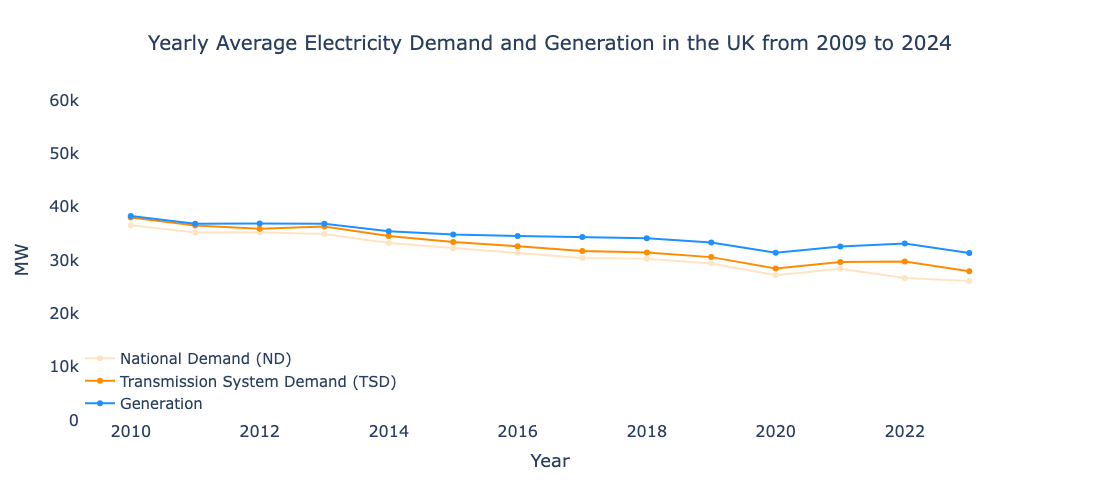

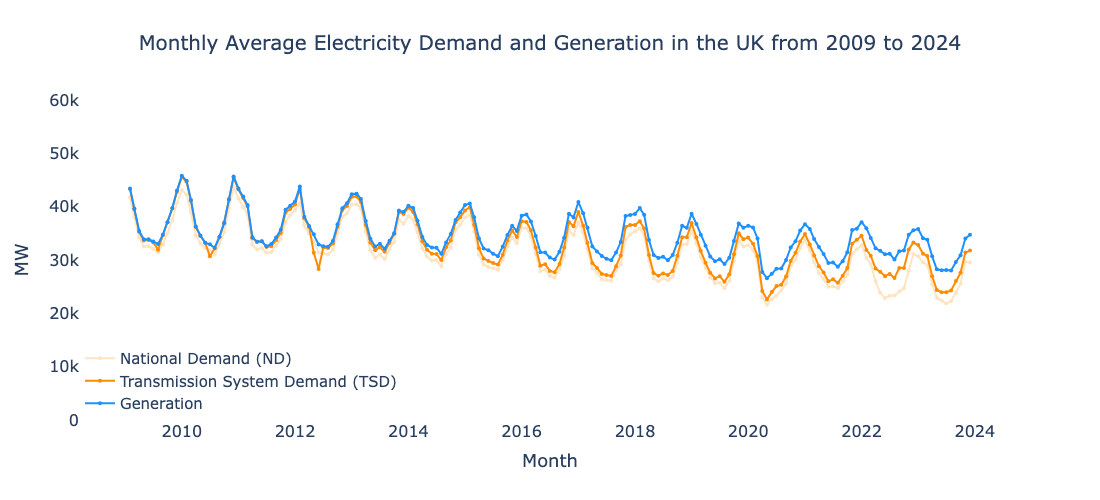

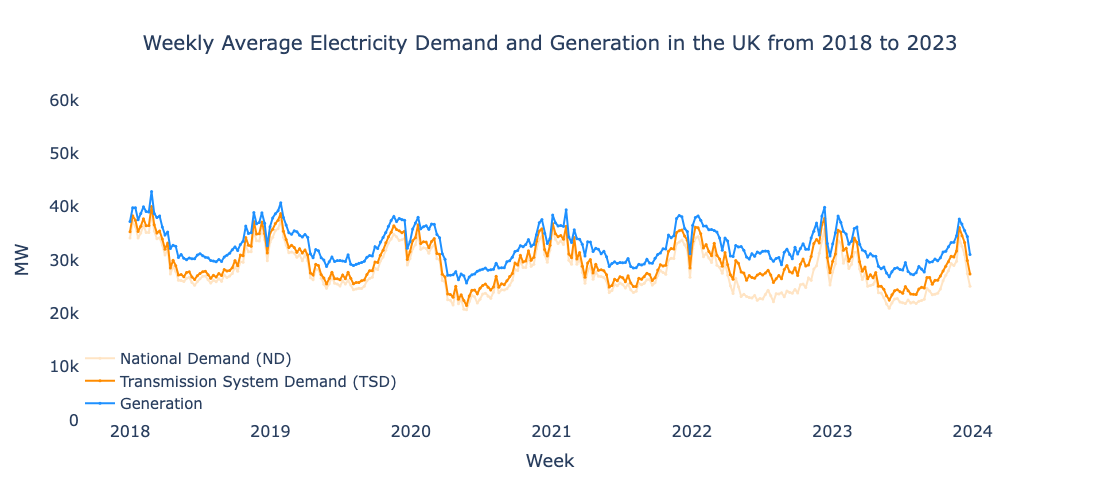

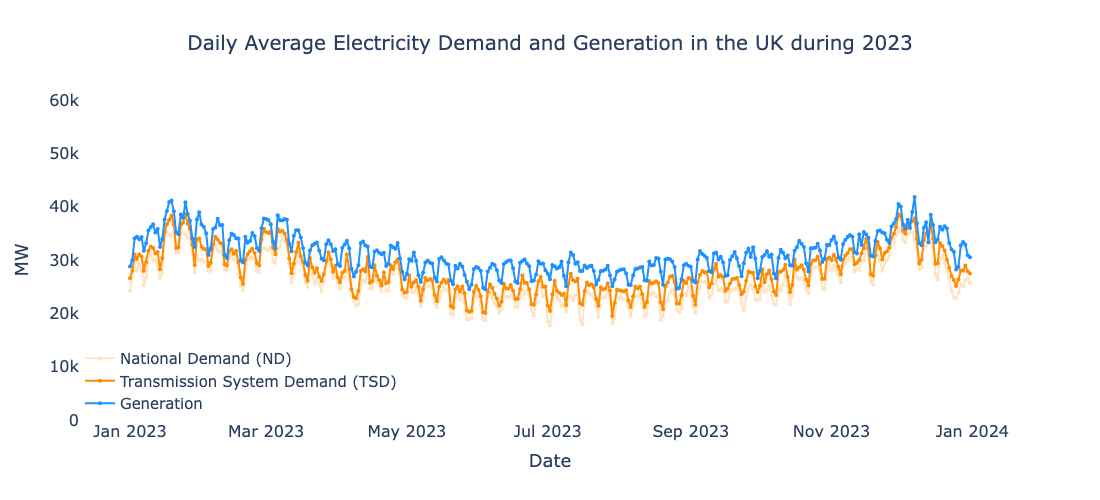

In [42]:
# Display yearly, monthly, weekly, daily PNG plots from the images folder
display(Image("../images/yearly.png"))
display(Image("../images/monthly.png"))
display(Image("../images/weekly.png"))
display(Image("../images/daily.png"))

## Some observations from the data

**Yearly average plot:**

- Steady decrease over the years
- Demand drops faster than generation, indicated by the growing gap between the too. UK has been selling more energy to adjacent energy markets (EU, Norway).

**Monthly average plot:**

- Yearly cycles.
- Energy consumption increases during winter. 

**Weekly average plot:**

- Demand drops significantly around the end of year.

**Daily average plot:**

- Weekly cycle.
- Less demand on weekends.
- Less demand on holidays (Christmas, Easter, New Year)

**Hourly average plot:**

- Daily cycle.
- High demand on workdays between 07:00 and 20:00.
- Also during the weekend, but to a lesser extend.

## Forecasting Demand

In [43]:
# Define train and test period
train_start = datetime(2013, 1, 1, 0, 0)
train_end = datetime(2023, 11, 30, 23, 59)
test_start = datetime(2023, 12, 1, 0, 0)
test_end = datetime(2023, 12, 31, 23, 59)

# Get the full actual data for plotting our forecasts (from 1st Dec to 31st Dec)
df_december = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd")
    ])
)

actual_future_mask = (df_december["datetime"] >= test_start) & (df_december["datetime"] <= test_end)
actual_future_times = df_december.filter(actual_future_mask)["datetime"].to_pandas()
actual_future_tsd = df_december.filter(actual_future_mask)["tsd"].to_numpy()

In [44]:
# Initialize results lists to store results RMSE and MAPE for each model
results_7_day_mean = []
results_gbr = []

In [45]:
# Count how many 24h windows fit in the test period with 24h step to set colormap
rolling_test_start = test_start
window_count = 0
while rolling_test_start + pd.Timedelta(hours=24) <= test_end:
    window_count += 1
    rolling_test_start += pd.Timedelta(hours=24)

window_count = window_count // 4 * 5
# Create colormap
cmap = cm.get_cmap('winter', window_count)


/var/folders/44/ht9jzlhn6k7cx0_d2g65xfpm0000gn/T/ipykernel_5807/1214235168.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [46]:
# Function to plot rolling 24h window predictions

def plot_rolling_predictions(
    times_list, preds_list, actual_times, actual_values, 
    colors, linestyles, title, xlabel, ylabel, 
    figsize=(18, 10), legend_loc='lower left', y_min=0
):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    # Plot actual
    for t, v, ls in zip(actual_times, actual_values, linestyles):
        plt.plot(t, v, color='black', linestyle=linestyles[0], label='Actual', zorder=1)
    # Plot predictions
    for i, (times, preds) in enumerate(zip(times_list, preds_list)):
        if i == 0:
            plt.plot(times, preds, color=colors(i), linestyle=linestyles[1], linewidth=4, alpha=0.9, label='Forecast', zorder=2)
        else:
            plt.plot(times, preds, color=colors(i), linestyle=linestyles[1], linewidth=4, alpha=0.9, zorder=2)
    plt.legend(loc=legend_loc, fontsize=18)
    plt.title(title, fontsize=20)
    plt.ylim(bottom=y_min)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.tight_layout()
    plt.show()


In [47]:
# Function to perform rolling window predictions and evaluations

def rolling_window_predictions(
    df_ml, test_start, test_end, window_hours, step_hours, 
    predict_func, cmap, plot_actual=None, plot_title="", 
    xlabel="Datetime", ylabel="Demand (MW)"
):
    import matplotlib.pyplot as plt
    results = []
    times_list = []
    preds_list = []
    rolling_test_start = test_start
    i = 0
    while rolling_test_start + pd.Timedelta(hours=step_hours) - pd.Timedelta(hours=window_hours) <= test_end:
        test_mask = (df_ml["datetime"] >= rolling_test_start) & (df_ml["datetime"] < rolling_test_start + pd.Timedelta(hours=window_hours))
        test_df = df_ml.filter(test_mask)
        times = test_df["datetime"].to_pandas()
        y_test = test_df["tsd"].to_numpy()
        preds = predict_func(test_df, times)
        rmse = root_mean_squared_error(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds)
        results.append({"test_start": rolling_test_start, "rmse": rmse, "mape": mape})
        times_list.append(times)
        preds_list.append(preds)
        if i == 0:
            first_window = pd.DataFrame({
                "datetime": times,
                "prediction": preds
            })
        rolling_test_start += pd.Timedelta(hours=step_hours)
        i += 1
    # Plot
    plot_rolling_predictions(
        times_list, preds_list, 
        [plot_actual[0]] if plot_actual else [], [plot_actual[1]] if plot_actual else [],
        cmap, ['solid', 'dotted'],
        plot_title, xlabel, ylabel
    )
    return results, first_window

**Baseline Model Predictions**


In [48]:
# Baseline prediction function: 7-day mean demand at the same time of day

def baseline_predict_func(test_df, times):
    baseline_pred = []
    for dt in times:
        mask = (
            (df_december["datetime"] < dt) &
            (df_december["datetime"] >= dt - pd.Timedelta(days=7)) &
            (df_december["datetime"].dt.hour() == dt.hour) &
            (df_december["datetime"].dt.minute() == dt.minute)
        )
        vals = df_december.filter(mask)["tsd"].to_numpy()
        baseline_pred.append(np.nanmean(vals) if len(vals) > 0 else np.nan)
    return np.array(baseline_pred)

Calculating baseline predictions...


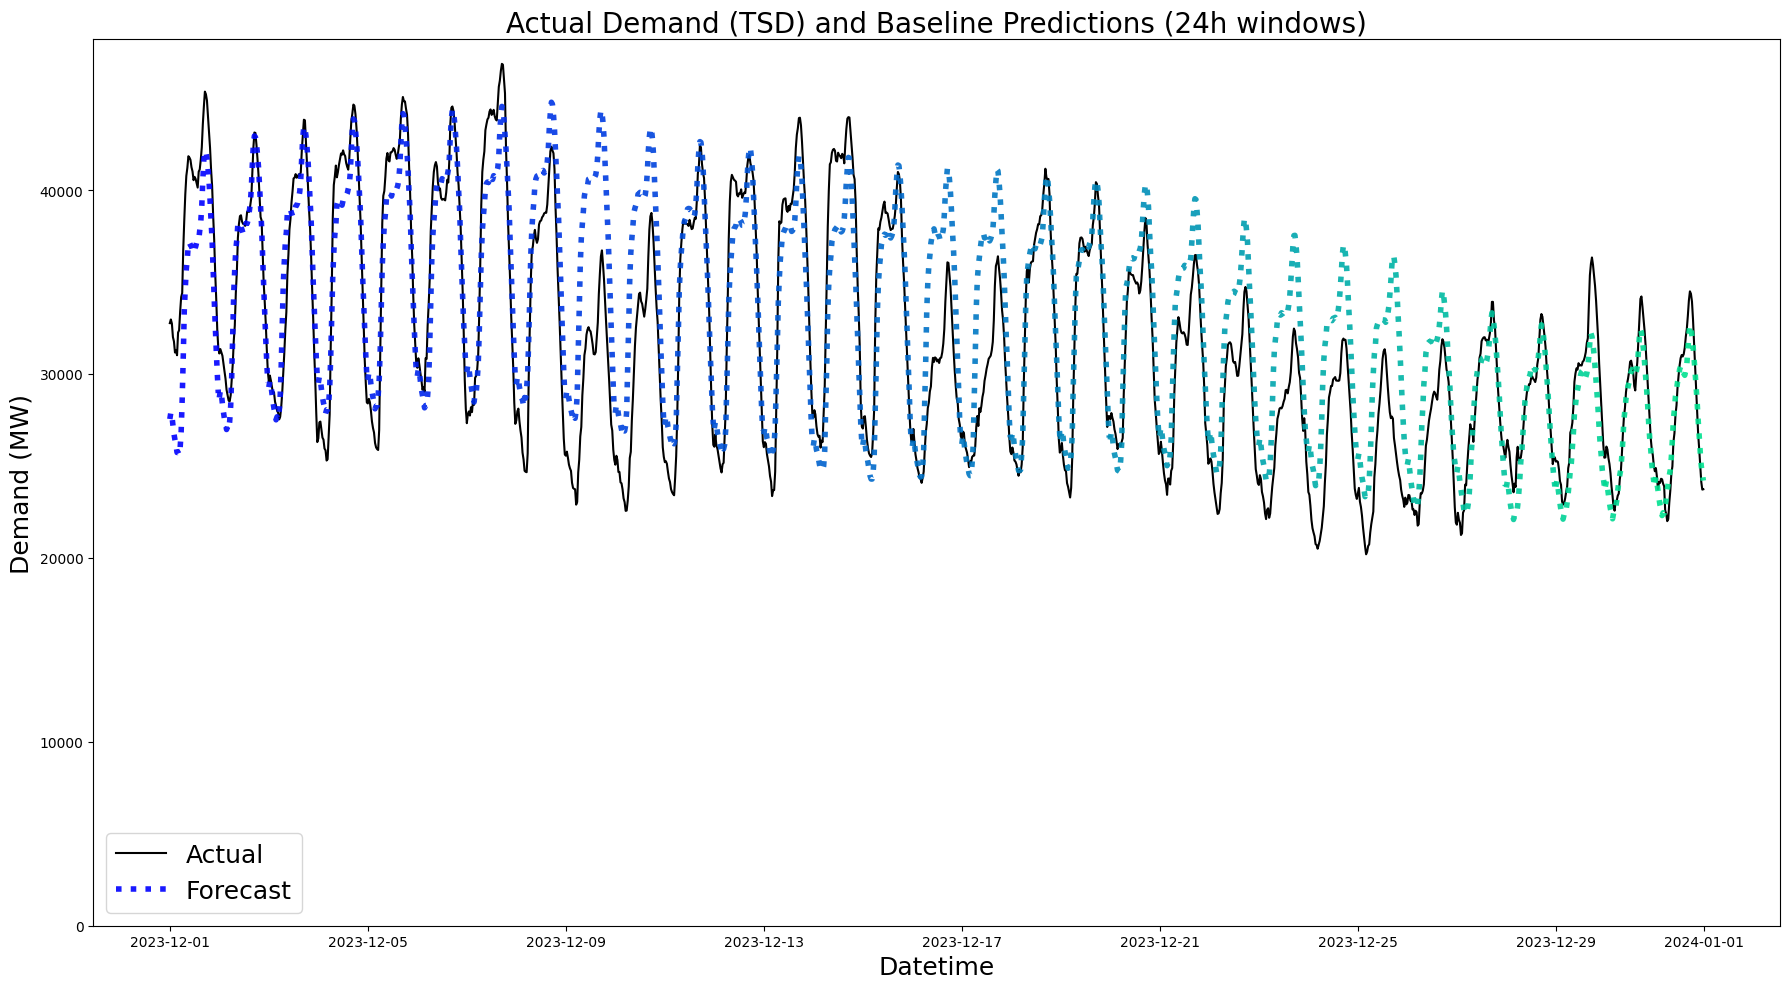

In [49]:
# Vizualize baseline model predictions
print("Calculating baseline predictions...")
time_start = time.time()
results_baseline, first_window_baseline = rolling_window_predictions(
    df_december, test_start, test_end, 24, 24, baseline_predict_func, cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and Baseline Predictions (24h windows)"
)
baseline_time = time.time() - time_start


In [50]:
# Print the scores
results_baseline_pd = pd.DataFrame(results_baseline)
baseline_rmse = results_baseline_pd['rmse'].mean()
baseline_mape = results_baseline_pd['mape'].mean()


print(f"   🔢 Time period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}\n")
print(f"   ⏱️  Calculation time: {baseline_time:.2f} seconds")
print(f"   📊 RMSE: {baseline_rmse:.2f} MW, MAPE: {baseline_mape:.3f}%")

   🔢 Time period: 2023-12-01 to 2023-12-31

   ⏱️  Calculation time: 8.14 seconds
   📊 RMSE: 2723.55 MW, MAPE: 0.079%


**ML models' predictions**

In [51]:
# Definining features for ML model
df_ml = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd"),

        # Time-based features both in linear and cyclical forms
        pl.col("datetime").dt.hour().alias("hour"),                # 0-23
        (2 * np.pi * pl.col("datetime").dt.hour() / 24).sin().alias("hour_sin"),  # 24-hour cycle
        (2 * np.pi * pl.col("datetime").dt.hour() / 24).cos().alias("hour_cos"),  # 24-hour cycle

        pl.col("datetime").dt.weekday().alias("day_of_week"),      # 0=Monday, 6=Sunday
        (2 * np.pi * pl.col("datetime").dt.weekday() / 7).sin().alias("weekday_sin"), # 7-day cycle
        (2 * np.pi * pl.col("datetime").dt.weekday() / 7).cos().alias("weekday_cos"), # 7-day cycle
        (pl.col("datetime").dt.weekday() >= 5).cast(pl.Int8).alias("is_weekend"),

        
        pl.col("datetime").dt.ordinal_day().alias("day_of_year"),  # 1-366
        (2 * np.pi * pl.col("datetime").dt.ordinal_day() / 365).sin().alias("day_of_year_sin"), # 365-day cycle
        (2 * np.pi * pl.col("datetime").dt.ordinal_day() / 365).cos().alias("day_of_year_cos"), # 365-day cycle

        pl.col("tsd").shift(48).alias("demand_lag_24h"),            # Demand 24 hours prior
        pl.col("tsd").shift(96).alias("demand_lag_48h"),            # Demand 48 hours prior
        pl.col("tsd").shift(672).alias("demand_lag_7d"),            # Demand 7 days prior
        pl.col("tsd").shift(3360).alias("demand_lag_14d"),          # Demand 14 days prior
        pl.col("tsd").shift(17520).alias("demand_lag_1y"),          # Demand 1 year (365 days) prior

        pl.col("is_holiday").alias("is_holiday"),

        pl.when(
        (pl.col("datetime").dt.hour() == 23) & (pl.col("datetime").dt.minute() == 30)
        )
        .then(pl.col("tsd"))  # 48 half-hours = 24 hours
        .otherwise(None)
        .forward_fill()
        .alias("last_known_value")
    ])
)

In [52]:
# Define features and targets
features_temp = ["hour", "day_of_week", "is_weekend", "day_of_year"]
features_temp_cyclic = [
    "hour_sin", "hour_cos",
    "weekday_sin", "weekday_cos",
    "day_of_year_sin", "day_of_year_cos",
    "is_weekend"
]
features_all_lags = ["demand_lag_24h", "demand_lag_48h", "demand_lag_7d", "demand_lag_14d", "demand_lag_1y", "last_known_value"]
features_holiday = ["is_holiday"]

features_ml = features_temp_cyclic + features_all_lags + features_holiday

target = "tsd"

In [53]:
# Prepare feature matrices and target vector
X_gbr = df_ml.select(features_ml)
X_lightgbm = df_ml.select(features_ml)
y = df_ml.select(target)

# Prepare training data
train_mask = (df_ml["datetime"] >= train_start) & (df_ml["datetime"] < test_start)

X_gbr_train = X_gbr.filter(train_mask).to_pandas()
X_lgbm_train = X_lightgbm.filter(train_mask).to_pandas()

y_train = y.filter(train_mask).to_numpy().ravel()

In [54]:
# Initialize of GradientBoostingRegressor model
model_gbr = GradientBoostingRegressor(
    n_estimators=200, max_depth=10, learning_rate=0.05, validation_fraction=0.1, random_state=7
    )

In [56]:
# Train Gradient Boosting Regressor model
print("Training Gradient Boosting Regressor model...")
time_start = time.time()

model_gbr.fit(X_gbr_train, y_train)
print("Gradient Boosting Regressor training completed.")

gbr_regular_time = time.time() - time_start

Training Gradient Boosting Regressor model...


Gradient Boosting Regressor training completed.


In [57]:
# Prediction function for ML model
def ml_predict_func(model, test_df, feature_names,  times):
    X_test = test_df[feature_names].to_pandas()
    return model.predict(X_test)


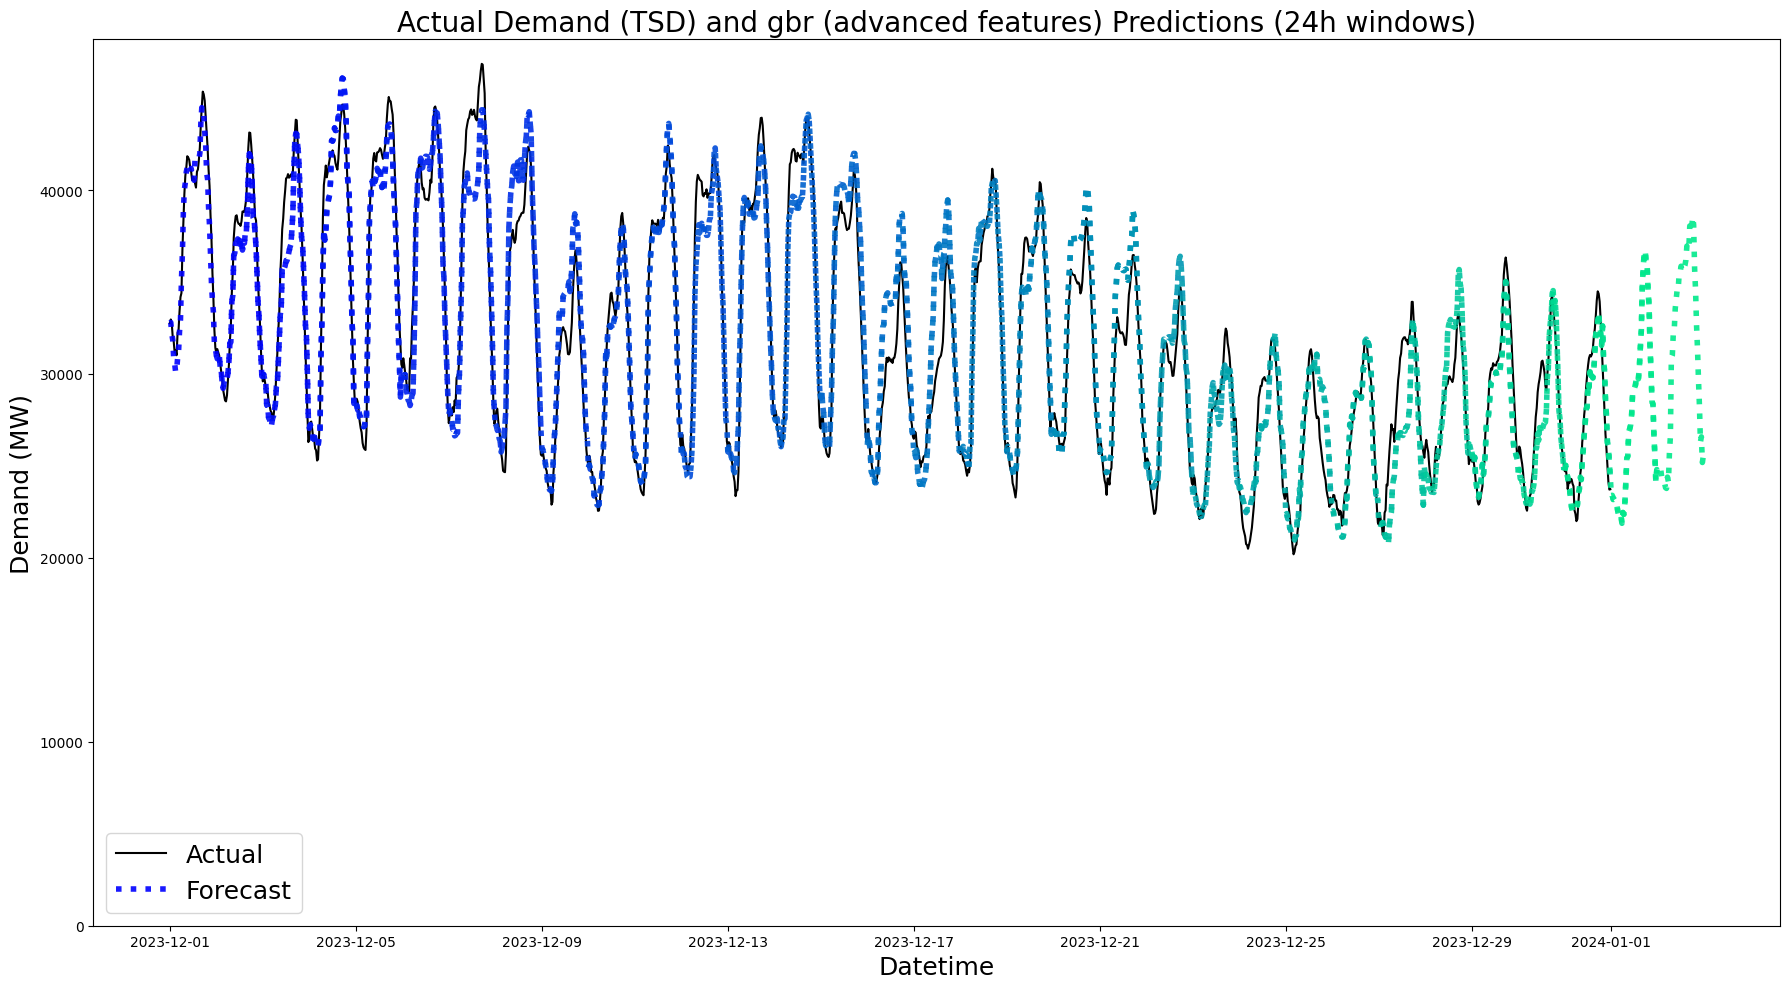

In [58]:
# Run rolling predictions for G model
results_gbr, first_window_gbr = rolling_window_predictions(
    df_ml, test_start, test_end, 48, 24,
    lambda test_df, times: ml_predict_func(model_gbr, test_df, features_ml, times),
    cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and gbr (advanced features) Predictions (24h windows)"
)

In [59]:
# Calculate and store results for regular GBR model
results_gbr_pd = pd.DataFrame(results_gbr)
gbr_regular_rmse = results_gbr_pd['rmse'].mean()
gbr_regular_mape = results_gbr_pd['mape'].mean()

print(f"   🔢 Training period: {train_start.strftime('%Y-%m-%d')} to {(test_start - timedelta(days=1)).strftime('%Y-%m-%d')}")
print(f"   ⏱️  Training time: {gbr_regular_time:.2f} seconds\n")

print(f"   🔢 Test period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
print(f"   📊 RMSE: {gbr_regular_rmse:.2f} MW, MAPE: {gbr_regular_mape:.3f}%")

if 'results' not in globals():
    results = {}

results['Regular_GBR'] = {
    'model': model_gbr,
    'training_time': gbr_regular_time,
    'rmse': gbr_regular_rmse,
    'mape': gbr_regular_mape
}

   🔢 Training period: 2013-01-01 to 2023-11-30
   ⏱️  Training time: 183.97 seconds

   🔢 Test period: 2023-12-01 to 2023-12-31
   📊 RMSE: 1668.08 MW, MAPE: 0.042%


In [60]:
# Creating validation split from training data for LightGBM
X_lgbm_train_split, X_lgbm_val_split, y_train_split, y_val_split = train_test_split(
    X_lgbm_train, y_train, test_size=0.2, random_state=7
)

In [61]:
# Intialize LightGBM model
model_lgbm = LGBMRegressor(
    n_estimators=200, max_depth=10, learning_rate=0.05, random_state=7
)   


In [62]:
# Train LightGBM model
print("Training LightGBM model...")
time_start = time.time()

model_lgbm.fit(
    X_lgbm_train_split, y_train_split,
    eval_set=[(X_lgbm_val_split, y_val_split)]
)
print("LightGBM training completed.")

lgbm_regular_time = time.time() - time_start

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 153044, number of used features: 14
[LightGBM] [Info] Start training from score 31447.493074
LightGBM training completed.


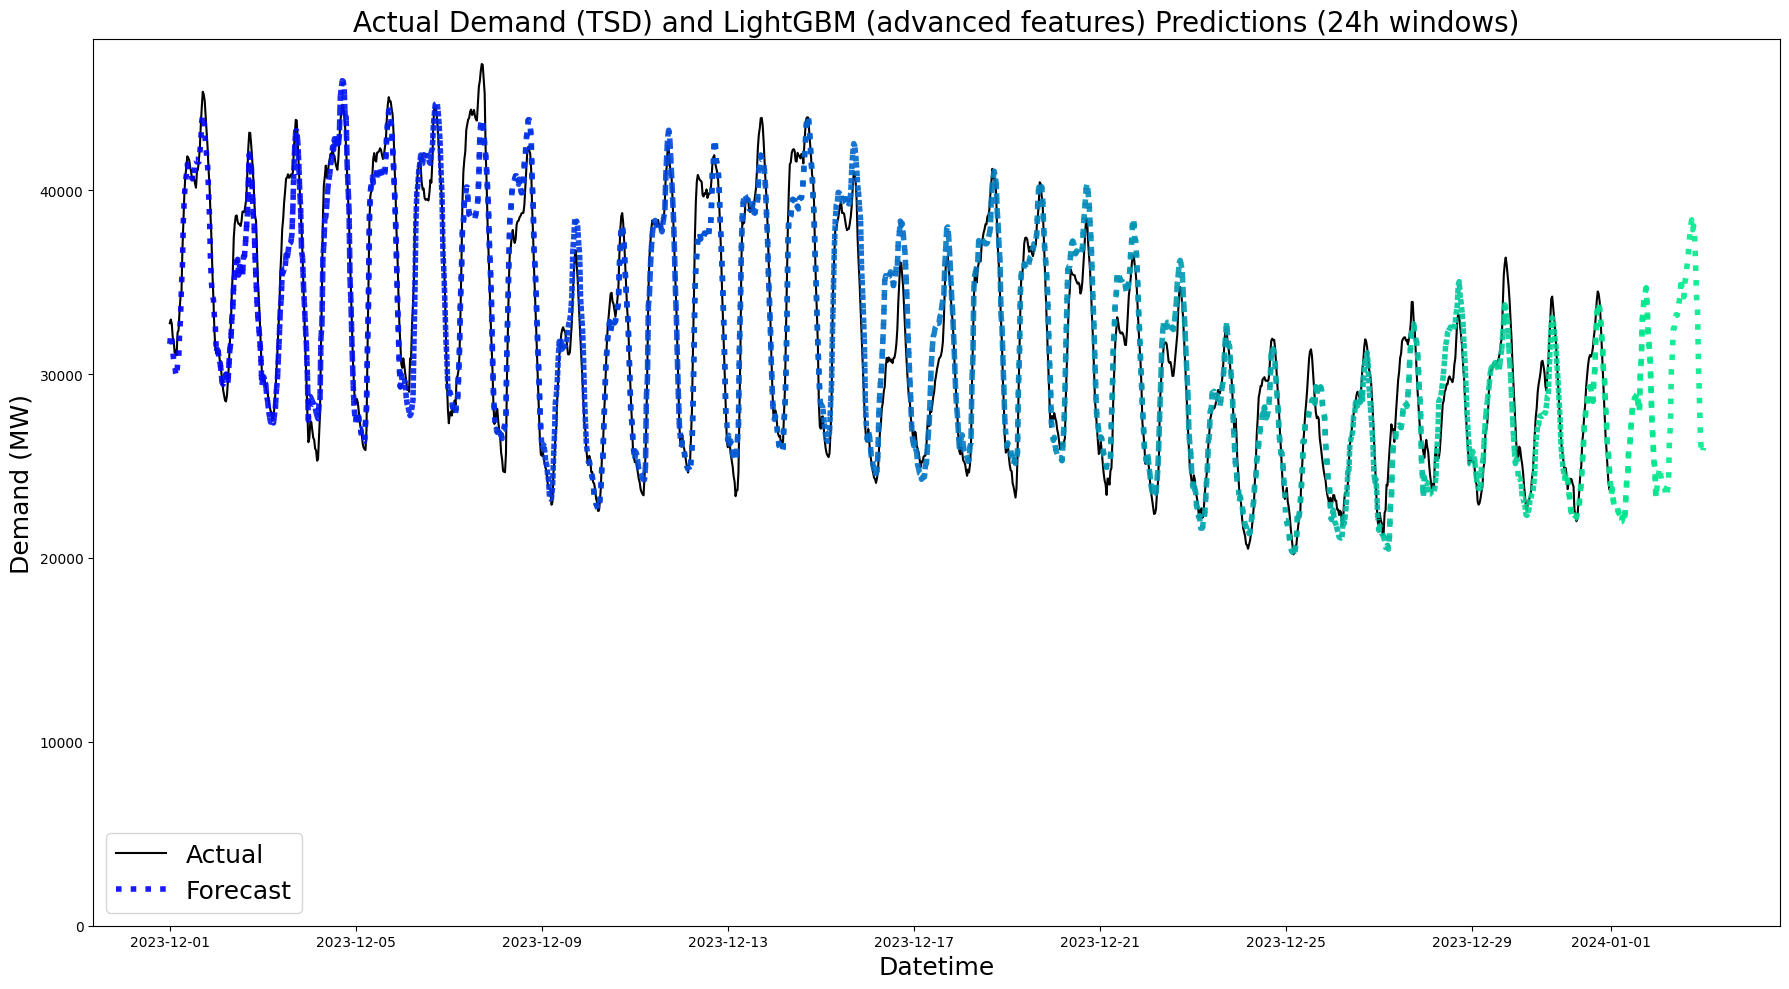

In [63]:
# Run rolling predictions for LightGBM model
results_lgbm, first_window_lgbm = rolling_window_predictions(
    df_ml, test_start, test_end, 48, 24,
    lambda test_df, times: ml_predict_func(model_lgbm, test_df, features_ml, times),
    cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and LightGBM (advanced features) Predictions (24h windows)"
)


In [64]:

# Calculate and store results for regular LightGBM model
results_lgbm_pd = pd.DataFrame(results_lgbm)
lgbm_regular_rmse = results_lgbm_pd['rmse'].mean()
lgbm_regular_mape = results_lgbm_pd['mape'].mean()

print(f"   🔢 Training period: {train_start.strftime('%Y-%m-%d')} to {(test_start - timedelta(days=1)).strftime('%Y-%m-%d')}")
print(f"   ⏱️  Training time: {lgbm_regular_time:.2f} seconds\n")

print(f"   🔢 Test period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
print(f"   📊 RMSE: {lgbm_regular_rmse:.2f} MW, MAPE: {lgbm_regular_mape:.3f}%")

if 'results' not in globals():
    results = {}

results['Regular_LGBM'] = {
    'model': model_lgbm,
    'training_time': lgbm_regular_time,
    'rmse': lgbm_regular_rmse,
    'mape': lgbm_regular_mape
}

   🔢 Training period: 2013-01-01 to 2023-11-30
   ⏱️  Training time: 1.30 seconds

   🔢 Test period: 2023-12-01 to 2023-12-31
   📊 RMSE: 1613.68 MW, MAPE: 0.041%


## Forecast comparison: the first 48h window 

In [65]:
# Prepare data for the first 48h window
actual_times = first_window_baseline["datetime"]
actual_values = df_ml.filter(
    (df_ml["datetime"] >= actual_times.iloc[0]) & (df_ml["datetime"] <= actual_times.iloc[-1])
)["tsd"].to_numpy()

# Forecasts for the first 48h window
baseline_pred = first_window_baseline["prediction"]
gbr_pred = first_window_gbr["prediction"]

# Plotly colors (same as in the last block)
color_baseline = '#ff7f0e'
color_gbr = '#bcbd22'
color_lgbm = '#2ca02c'

fig = go.Figure()

# Actual (solid black)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=actual_values,
    mode='lines',
    name='Actual',
    line=dict(color='black', width=2, dash='solid')
))

# Baseline forecast (dotted)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=baseline_pred,
    mode='lines+markers',
    name='Baseline: 7-day mean',
    line=dict(color=color_baseline, width=3, dash='dot'),
    marker=dict(color=color_baseline)
))

# Gradient Boosting Regressor forecast (dotted)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=gbr_pred,
    mode='lines+markers',
    name='Gradient Boosting Regressor',
    line=dict(color=color_gbr, width=3, dash='dot'),
    marker=dict(color=color_gbr)
))

# LightGBM forecast (dotted)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=first_window_lgbm["prediction"],
    mode='lines+markers',
    name='Light Gradient Boosting Machine',
    line=dict(color=color_lgbm, width=3, dash='dot'),
    marker=dict(color=color_lgbm)
))

fig.update_layout(
    title="First 24h Window: Actual vs Forecasts",
    xaxis_title="Datetime",
    yaxis_title="Demand (MW)",
    title_font=dict(size=20),
    title_x=0.5,
    plot_bgcolor='whitesmoke',
    legend=dict(font=dict(size=16)),
    width=1100,
    height=500
)

fig.show()

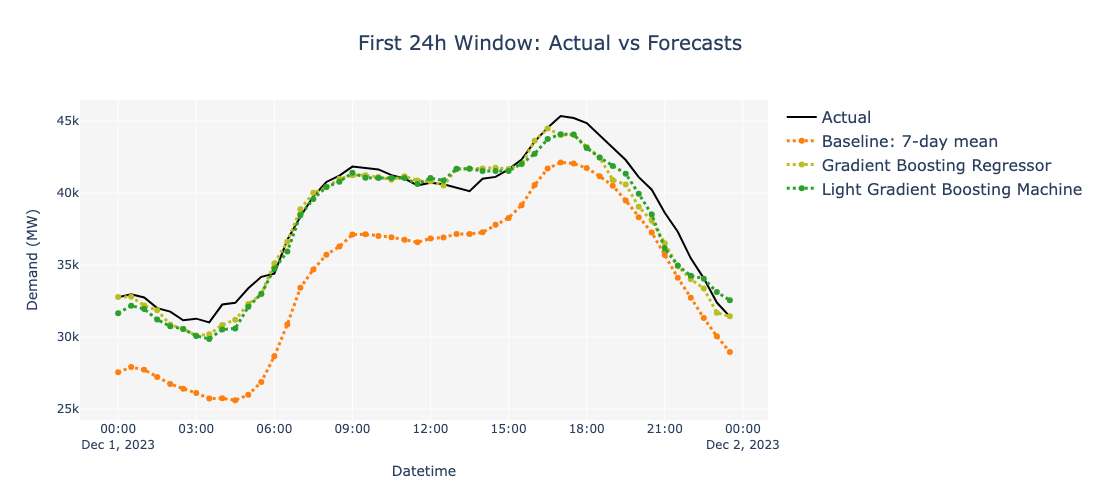

In [66]:
display(Image("../images/24h_window.png"))

## Forecast comparison: RMSE throught the whole month of December 2023

In [67]:
# Make x axis go from 1 to 31 (all December days)
x_days = list(range(1, 32))

# Prepare y values for each model, filling missing days with None for gaps
def fill_rmse_by_day(results_df):
    rmse_by_day = {d.day: v for d, v in zip(results_df["test_start"], results_df["rmse"])}
    return [rmse_by_day.get(day, None) for day in x_days]

y_7d = fill_rmse_by_day(pd.DataFrame(results_baseline))
y_gbr = fill_rmse_by_day(pd.DataFrame(results_gbr))
y_lgbm = fill_rmse_by_day(pd.DataFrame(results_lgbm))

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_7d,
    mode='lines+markers',
    name='Baseline: 7-day mean',
    line=dict(color=color_baseline)
))
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_gbr,
    mode='lines+markers',
    name='Gradient Boosting Regressor (GBR)',
    line=dict(color=color_gbr)
))
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_lgbm,
    mode='lines+markers',
    name='Light Gradient Boosting Machine (LightGBM)',
    line=dict(color=color_lgbm)
))


fig.update_layout(
    title="Comparison of different energy demand forecasting methods for December 2023 in the UK",
    xaxis_title="Day of December",
    yaxis_title="RMSE (MW)",
    plot_bgcolor='whitesmoke',
    legend=dict(
        font=dict(size=18),
        x=1,
        y=1,
        xanchor='right',
        yanchor='top'
    ),
    title_font=dict(size=20),
    title_x=0.5,
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        range=[0.1, 31],
        tickfont=dict(size=16),
        title_font=dict(size=18)
    ),
    yaxis=dict(
        range=[0, 7999],
        tickfont=dict(size=16), 
        title_font=dict(size=18)
        ),
    width=1100,
    height=500
)

fig.show()

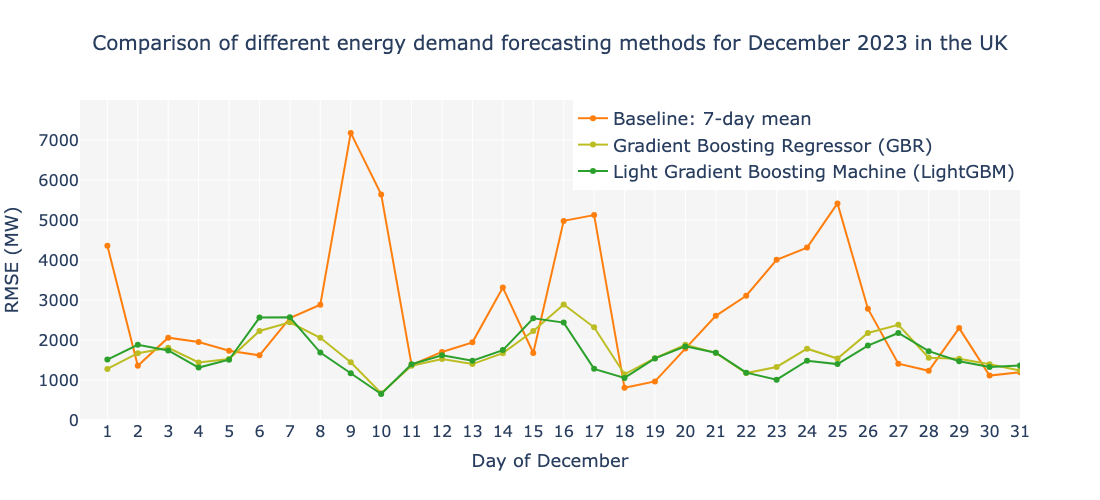

In [68]:
display(Image("../images/RMSE.png"))


## Feature Importance

In [69]:
def test_feature_importance_plot(model, features):
    1,4
    # Get importances depending on model type
    if isinstance(model, GradientBoostingRegressor):
        importances = model.feature_importances_

    # LightGBM model by default uses 'split' importance, we use 'gain' here for consistency
    
    elif isinstance(model, LGBMRegressor):
        importances = model.booster_.feature_importance(importance_type='gain')
    else:
        raise ValueError("Model type not supported for feature importance plot.")

    # Normalize importances to sum to 1.0 for comparison
    normalized_importances = importances / importances.sum()
    feature_names = features

    # Sort features by importance
    indices = np.argsort(normalized_importances)[::-1]
    sorted_names = [feature_names[i] for i in indices]
    sorted_importances = normalized_importances[indices]

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_names, sorted_importances, color='dodgerblue')
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances for ' + type(model).__name__)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



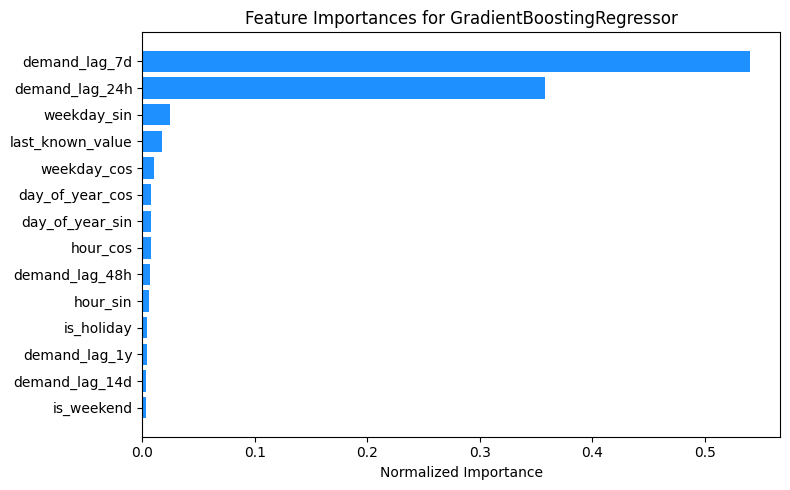

In [70]:
# Feature importance test for Gradient Boosting Regressor
test_feature_importance_plot(model_gbr, features_ml)

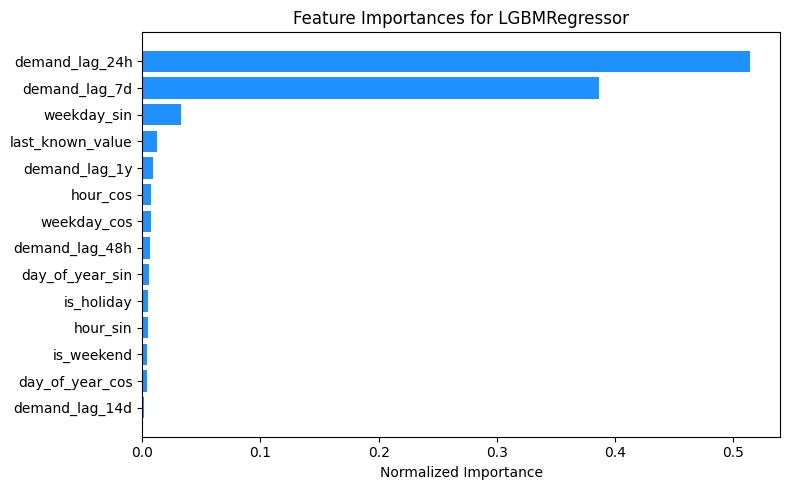

In [71]:
# Feature importance test for light Gradient Boosting Machine
test_feature_importance_plot(model_lgbm, features_ml)

## Conclusions:

**Lag and last known demand features are the most important**: Including value 24h ago and 7d ago as well as the last known value before the forecast window, are key to the models' ability to forecast demand, as shown by the feature importance plots

**Temporal features help:** Features like 'day_of_week_sin'/cos, 'hour_sin'/cos, and 'day_of_year_sin'/cos capture weekly and daily cycles, seasonality, which are important for electricity demand forecasting.

**Baseline is outperformed:** Both models significantly outperform the 7-day mean baseline, confirming that advanced machine learning models with rich temporal and lagged features provide superior predictive accuracy.

**Model choice is important:** The LightGBM model achieves the lowest RMSE and MAPE, slightly outperforming the Gradient Boosting Regressor (GBR) with the same feature set, while taking significantly less time to train (1.46 s vs 191.12 s). 


## Ways to improve

**Add weather data:** temperature could be useful to predict heating/cooling associated electricity demands.

**Tune hyperparameters:** Use grid search or Bayesian optimization to find the best model parameters.

**Handle special cases:** Daylight saving creates duplicate/missing time intances, which could affect forecasting.

**Ensemble methods:** Combine predictions from multiple models to reduce variance and improve accuracy.
